In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-drcsikdj because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
# actually this is all points, not just start points
start_points = all_points[:,:,1:].reshape(-1,7)
print("start_points_shape", start_points.shape)
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
#start_points = start_points[:,3:]
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
start_points_shape (9920, 7)
std of:  0.17859106200728153
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00082463 0.00106736 0.00316102 0.00634536 0.0256     0.00564557
 0.00894256]


In [4]:
dataset = start_points
dataset

array([[ 5.30630546e-02, -7.39897730e-02,  6.99848376e-02, ...,
         5.77279855e-02,  3.91912119e-02,  2.56211944e-02],
       [ 4.82265267e-02, -6.74389532e-02,  6.44204345e-02, ...,
         5.95007100e-02,  3.93298113e-02,  2.38431718e-02],
       [ 4.42146147e-02, -6.03095820e-02,  5.96689720e-02, ...,
         6.08009003e-02,  3.93789762e-02,  2.20194015e-02],
       ...,
       [-9.03704476e-03,  1.13378370e-01,  8.72505381e-02, ...,
        -7.04652473e-02, -2.69143945e-02, -1.99310649e-01],
       [-2.72879079e-03,  1.19000039e-01,  1.06496165e-01, ...,
        -9.01796312e-02, -2.89765200e-02, -2.14355879e-01],
       [-1.67703832e-05,  1.42264068e-01,  1.38627073e-01, ...,
        -1.05488737e-01, -2.73580771e-02, -2.35037893e-01]])

In [5]:
np.random.seed(1)
train_indices = np.random.choice(len(dataset),100,replace=False)
test_indices = [i for i in range(len(dataset)) if i not in train_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]
print(train_dataset.shape,test_dataset.shape)

(100, 7) (9820, 7)


In [6]:
print(train_indices[:10])

[5757 8972 1984 5830 1945 3869 1172 1217 2311  691]


<IPython.core.display.Javascript object>


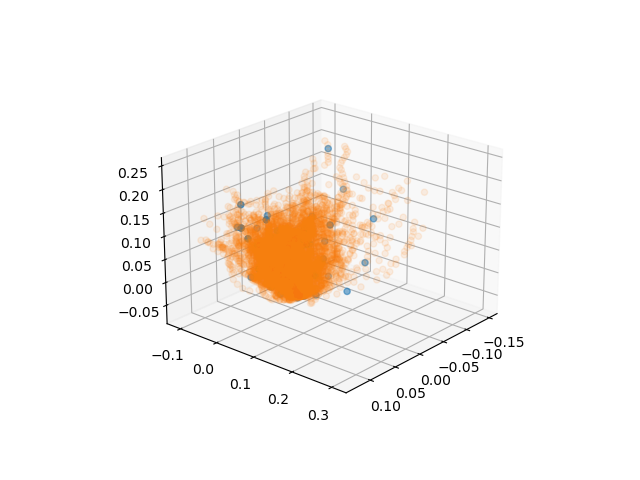

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2],alpha=0.1);

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cpu"
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
def train_and_apply_pca_model(latent_dim, train_data, test_data):
    latentdim = latent_dim
    train_dataset_mean =  np.mean(train_data,axis=0)
    u,s,vt = np.linalg.svd(train_data-train_dataset_mean)
    trainmodeleduats = (train_data-train_dataset_mean) @ vt[:latentdim,:].T
    recon = trainmodeleduats @ vt[:latentdim,:] + train_dataset_mean
    testmodeleduats = (test_data-train_dataset_mean) @ vt[:latentdim,:].T
    testrecon = testmodeleduats @ vt[:latentdim,:] + train_dataset_mean
    error = recon - train_data
    testerror = testrecon  - test_data
    trainrmse = np.sqrt(np.mean(np.sum(np.square(error),axis=1)))
    testrmse = np.sqrt(np.mean(np.sum(np.square(testerror),axis=1)))
    return (trainrmse, testrmse)

In [16]:
for latdim in range(4):
    print(train_and_apply_pca_model(latdim,train_dataset,test_dataset))

(0.22419371587397705, 0.2280505547284446)
(0.14522424739834378, 0.14321458052304378)
(0.10528128829504901, 0.10464429348233918)
(0.07626925807955225, 0.07492719427840255)


In [13]:
train_and_apply_pca_model(1,train_dataset,test_dataset)

(0.14522424739834378, 0.14321458052304378)

In [14]:
train_and_apply_pca_model(0,train_dataset,test_dataset)

(0.22419371587397705, 0.2280505547284446)

In [15]:
latentdim = 2
train_dataset_mean =  np.mean(train_dataset,axis=0)
u,s,vt = np.linalg.svd(train_dataset-train_dataset_mean)
recon = u[:,:latentdim] @ np.diag(s[:latentdim]) @ vt[:latentdim,:]
error = recon + train_dataset_mean - train_dataset
print(np.sqrt(np.mean(np.sum(np.square(error),axis=1))))

0.105281288295049
